In [1]:
import numpy as np
import pandas as pd
import time
import urllib.request
import io
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc,
    classification_report,
    recall_score
)
from sklearn.model_selection import StratifiedKFold

class LinearSVMClassifier:
    """
    Linear Support Vector Machine Classifier for Breast Cancer Diagnosis

    Optimized for minimizing false negatives in medical diagnosis scenarios.
    """
    def __init__(self, n_folds=6):
        """
        Initialize the Linear SVM Classifier with False Negative Minimization Strategy

        Parameters:
        -----------
        n_folds : int, default=6
            Number of folds for cross-validation
        """
        self.n_folds = n_folds
        self.metrics = {
            'recalls': [],
            'false_negatives': [],
            'accuracies': [],
            'conf_matrices': [],
            'thresholds': [],
            'aucs': [],
            'runtimes': [],
            'detailed_reports': []
        }

    @staticmethod
    def load_wdbc_dataset(url='https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'):
        """
        Load and preprocess Breast Cancer Wisconsin (Diagnostic) Dataset

        Returns:
        --------
        pd.DataFrame: Processed dataset
        """
        try:
            # Download the data
            response = urllib.request.urlopen(url)
            data = response.read().decode('utf-8')

            # Create DataFrame
            columns = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 31)]
            df_wdbc = pd.read_csv(io.StringIO(data), header=None, names=columns)

            # Preprocess the data
            df_wdbc.drop("ID", axis=1, inplace=True)
            df_wdbc["Diagnosis"] = df_wdbc["Diagnosis"].map({"M": 1, "B": 0})

            return df_wdbc
        except Exception as e:
            print(f"Error loading dataset: {e}")
            return None

    '''def _find_false_negative_minimizing_threshold(self, y_test, y_probs):
      """
      Find the threshold that minimizes false negatives with a lower bound of 0.15

      Parameters:
      -----------
      y_test : array
          True binary labels
      y_probs : array
          Predicted probabilities for positive class

      Returns:
      --------
      tuple: (optimal threshold, false positive rates, true positive rates)
      """
      # ROC Curve Computation
      fpr, tpr, thresholds = roc_curve(y_test, y_probs)

      # Filter thresholds to ensure they are not below 0.15
      valid_threshold_indices = np.where(thresholds >= 0.15)[0]

      # Prepare lists to track performance
      false_negatives = []
      recalls = []
      valid_thresholds = thresholds[valid_threshold_indices]

      # Iterate through valid potential thresholds
      for threshold in valid_thresholds:
          # Predict based on current threshold
          y_pred = (y_probs >= threshold).astype(int)

          # Compute false negatives and recall
          fn = np.sum((y_test == 1) & (y_pred == 0))
          recall = recall_score(y_test, y_pred)

          false_negatives.append(fn)
          recalls.append(recall)

      # Find threshold with minimum false negatives among valid thresholds
      min_fn_idx = np.argmin(false_negatives)
      optimal_threshold = valid_thresholds[min_fn_idx]

      # Corresponding indices for plotting
      optimal_fpr_idx = np.where(thresholds == optimal_threshold)[0][0]

      # Detailed Reporting
      print("\nFalse Negative Minimization Analysis:")
      print(f"Optimal Threshold: {optimal_threshold:.4f}")
      print(f"Minimum False Negatives: {false_negatives[min_fn_idx]}")
      print(f"Recall at Optimal Threshold: {recalls[min_fn_idx]:.4f}")
      print(f"Threshold Lower Bound Respected: Yes (Minimum: 0.15)")

      return optimal_threshold, fpr, tpr'''

    def _find_false_negative_minimizing_threshold(self, y_test, y_probs):
        """
        Find the threshold that minimizes false negatives with detailed analysis

        Parameters:
        -----------
        y_test : array
            True binary labels
        y_probs : array
            Predicted probabilities for positive class

        Returns:
        --------
        tuple: (optimal threshold, false positive rates, true positive rates)
        """
        # ROC Curve Computation
        fpr, tpr, thresholds = roc_curve(y_test, y_probs)

        # Prepare lists to track performance
        false_negatives = []
        recalls = []

        # Iterate through potential thresholds
        for threshold in thresholds:
            # Predict based on current threshold
            y_pred = (y_probs >= threshold).astype(int)

            # Compute false negatives and recall
            fn = np.sum((y_test == 1) & (y_pred == 0))
            recall = recall_score(y_test, y_pred)

            false_negatives.append(fn)
            recalls.append(recall)

        # Find threshold with minimum false negatives
        min_fn_idx = np.argmin(false_negatives)
        optimal_threshold = thresholds[min_fn_idx]

        # Detailed Reporting
        print("\nFalse Negative Minimization Analysis:")
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Minimum False Negatives: {false_negatives[min_fn_idx]}")
        print(f"Recall at Optimal Threshold: {recalls[min_fn_idx]:.4f}")

        return optimal_threshold, fpr, tpr

    def cross_validation_svm_classification(self, X, y):
        """
        Perform comprehensive cross-validation with False Negative Minimization

        Parameters:
        -----------
        X : numpy.ndarray
            Feature matrix
        y : numpy.ndarray
            Target vector

        Returns:
        --------
        dict: Comprehensive performance metrics
        """
        # Reset previous results
        for metric_list in self.metrics.values():
            metric_list.clear()

        # Stratified K-Fold Cross Validation
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        # Prepare ROC plot
        plt.figure(figsize=(15, 10))

        # Cross-validation loop
        for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
            # Data split
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Time the training and evaluation
            start_time = time.time()

            # Train Linear SVM
            svm_clf = SVC(kernel="linear", probability=True, random_state=42)
            svm_clf.fit(X_train, y_train)

            # Predict probabilities
            y_probs = svm_clf.predict_proba(X_test)[:, 1]

            # Find threshold minimizing false negatives
            optimal_threshold, fpr, tpr = self._find_false_negative_minimizing_threshold(y_test, y_probs)

            # Compute AUC
            roc_auc = auc(fpr, tpr)
            self.metrics['aucs'].append(roc_auc)

            # Predictions using optimal threshold
            y_pred = (y_probs >= optimal_threshold).astype(int)

            # Performance metrics
            accuracy = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            false_negatives = np.sum((y_test == 1) & (y_pred == 0))

            # Store metrics
            self.metrics['accuracies'].append(accuracy)
            self.metrics['recalls'].append(recall)
            self.metrics['false_negatives'].append(false_negatives)

            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            self.metrics['conf_matrices'].append(cm)

            # Detailed Classification Report
            detailed_report = classification_report(y_test, y_pred)
            self.metrics['detailed_reports'].append(detailed_report)

            # Thresholds and Runtime
            self.metrics['thresholds'].append(optimal_threshold)
            runtime = time.time() - start_time
            self.metrics['runtimes'].append(runtime)

            # Plot ROC curve for this fold
            plt.plot(fpr, tpr, lw=2, label=f'Fold {fold_idx + 1} (AUC = {roc_auc:.2f})')

        # Finalize ROC plot
        plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color='gray', label="Random Classifier")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves\nOptimized for False Negative Minimization')
        plt.legend(loc="lower right")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Compute and return summary metrics
        return {
            'Average Accuracy': np.mean(self.metrics['accuracies']),
            'Average Recall': np.mean(self.metrics['recalls']),
            'Average False Negatives': np.mean(self.metrics['false_negatives']),
            'Average AUC': np.mean(self.metrics['aucs']),
            'Average Runtime (seconds)': np.mean(self.metrics['runtimes']),
            'Optimal Thresholds': self.metrics['thresholds'],
            'Confusion Matrices': self.metrics['conf_matrices'],
            'Detailed Classification Reports': self.metrics['detailed_reports']
        }

In [2]:
def main():
    """
    Main execution function for Linear SVM Classification
    Optimized for False Negative Minimization in Breast Cancer Diagnosis
    """
    # Report header
    print("=" * 60)
    print("Breast Cancer Diagnosis: Linear SVM Classifier")
    print("False Negative Minimization Performance Report")
    print("=" * 60)

    # Load the dataset
    df_wdbc = LinearSVMClassifier.load_wdbc_dataset()

    if df_wdbc is not None:
        # Data preparation
        X = df_wdbc.drop("Diagnosis", axis=1).values
        y = df_wdbc["Diagnosis"].values

        # Initialize and run SVM classifier
        svm_classifier = LinearSVMClassifier(n_folds=6)
        results = svm_classifier.cross_validation_svm_classification(X, y)

        # Report results
        print("\n1. Performance Metrics:")
        print(f" Average Accuracy: {results['Average Accuracy']:.4f}")
        print(f" Average Recall (Sensitivity): {results['Average Recall']:.4f}")
        print(f" Average Number of False Negatives: {results['Average False Negatives']:.2f}")
        print(f" Average AUC Score: {results['Average AUC']:.4f}")
        print(f" Average Runtime: {results['Average Runtime (seconds)']:.4f} seconds")

        print("\n2. Threshold Values:")
        for idx, threshold in enumerate(results['Optimal Thresholds'], 1):
            print(f" Fold {idx} Optimal Threshold: {threshold:.4f}")

        print("\n3. Confusion Matrices:")
        for idx, cm in enumerate(results['Confusion Matrices'], 1):
            print(f"\n Fold {idx} Confusion Matrix:")
            print(cm)

        print("\n4. Detailed Classification Reports:")
        for idx, report in enumerate(results['Detailed Classification Reports'], 1):
            print(f"\n Fold {idx} Detailed Report:")
            print(report)

Breast Cancer Diagnosis: Linear SVM Classifier
False Negative Minimization Performance Report

False Negative Minimization Analysis:
Optimal Threshold: 0.3072
Minimum False Negatives: 0
Recall at Optimal Threshold: 1.0000

False Negative Minimization Analysis:
Optimal Threshold: 0.1939
Minimum False Negatives: 0
Recall at Optimal Threshold: 1.0000

False Negative Minimization Analysis:
Optimal Threshold: 0.0009
Minimum False Negatives: 0
Recall at Optimal Threshold: 1.0000

False Negative Minimization Analysis:
Optimal Threshold: 0.2121
Minimum False Negatives: 0
Recall at Optimal Threshold: 1.0000

False Negative Minimization Analysis:
Optimal Threshold: 0.2572
Minimum False Negatives: 0
Recall at Optimal Threshold: 1.0000

False Negative Minimization Analysis:
Optimal Threshold: 0.2790
Minimum False Negatives: 0
Recall at Optimal Threshold: 1.0000


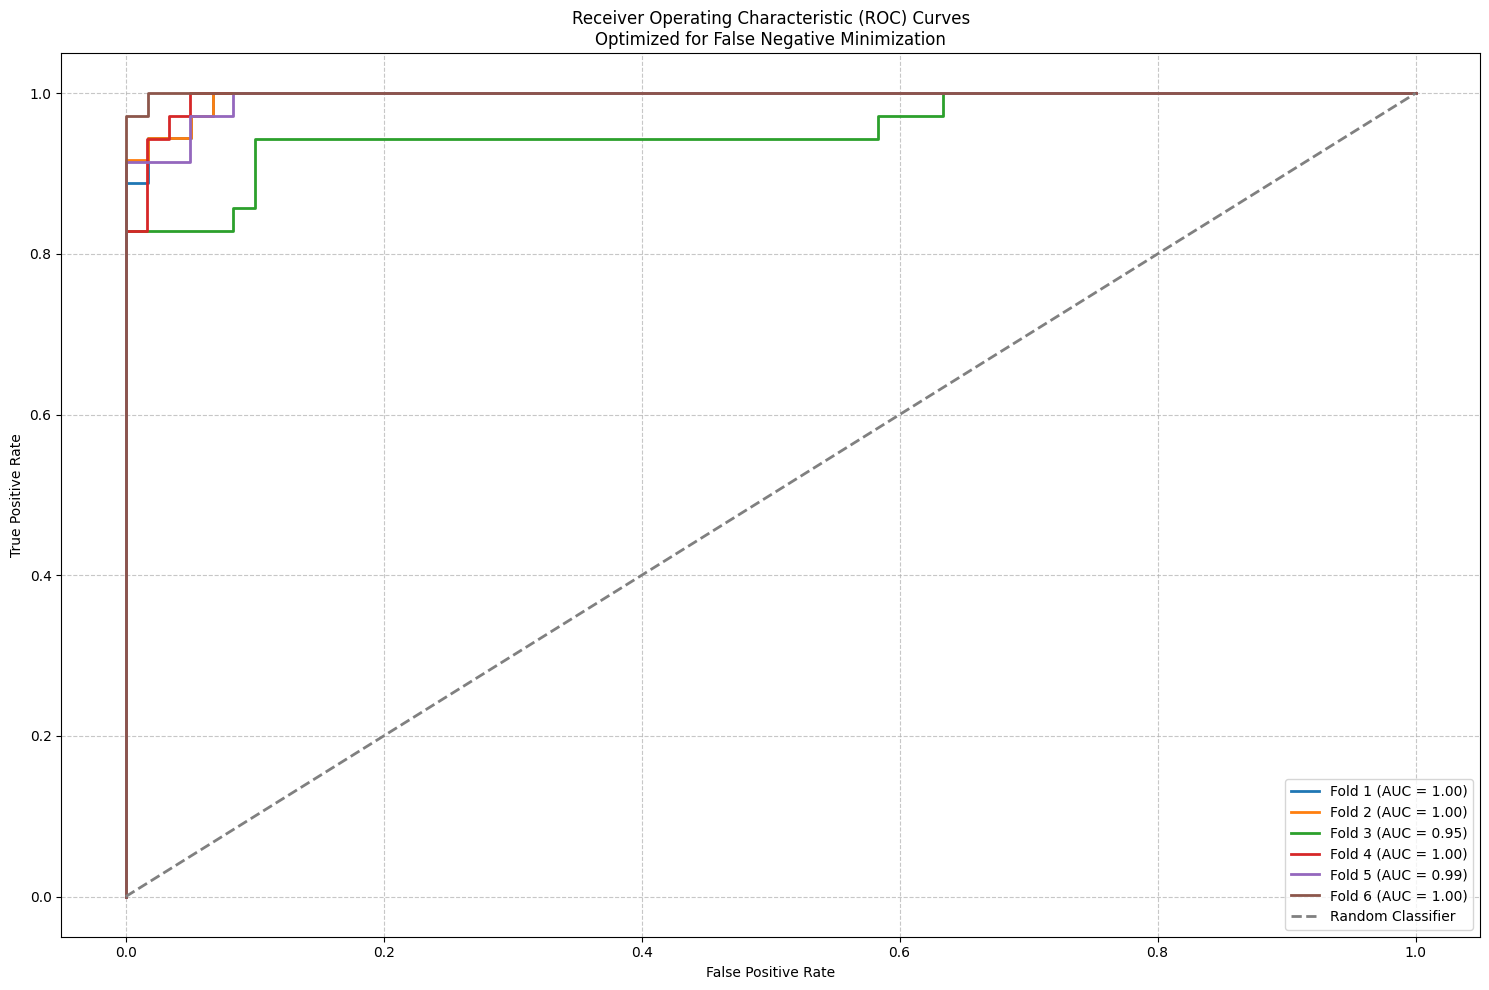


1. Performance Metrics:
 Average Accuracy: 0.9035
 Average Recall (Sensitivity): 1.0000
 Average Number of False Negatives: 0.00
 Average AUC Score: 0.9894
 Average Runtime: 10.3283 seconds

2. Threshold Values:
 Fold 1 Optimal Threshold: 0.3072
 Fold 2 Optimal Threshold: 0.1939
 Fold 3 Optimal Threshold: 0.0009
 Fold 4 Optimal Threshold: 0.2121
 Fold 5 Optimal Threshold: 0.2572
 Fold 6 Optimal Threshold: 0.2790

3. Confusion Matrices:

 Fold 1 Confusion Matrix:
[[55  4]
 [ 0 36]]

 Fold 2 Confusion Matrix:
[[55  4]
 [ 0 36]]

 Fold 3 Confusion Matrix:
[[22 38]
 [ 0 35]]

 Fold 4 Confusion Matrix:
[[57  3]
 [ 0 35]]

 Fold 5 Confusion Matrix:
[[55  5]
 [ 0 35]]

 Fold 6 Confusion Matrix:
[[58  1]
 [ 0 35]]

4. Detailed Classification Reports:

 Fold 1 Detailed Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        59
           1       0.90      1.00      0.95        36

    accuracy                           0.96        95
  

In [4]:
if __name__ == "__main__":
    main()

# Class Structure and Design

The first step in implementation was designing a dedicated **LinearSVMClassifier** class. This object-oriented approach allowed for encapsulating both the model and evaluation logic in a cohesive structure. The class was designed with a focus on minimizing false negatives in medical diagnosis, which led to specialized threshold optimization methods. The class manages various performance metrics, including recalls, false negatives, accuracies, confusion matrices, thresholds, AUC scores, runtimes, and detailed classification reports, providing a comprehensive basis for model evaluation.


# Data Preprocessing

The Wisconsin Diagnostic Breast Cancer dataset was selected for this task due to its relevance to the medical diagnosis problem domain. A specialized static method *load_wdbc_dataset()* was implemented to download the dataset directly from the UCI Machine Learning Repository, ensuring reproducibility of results. The preprocessing steps included:

Creating a structured DataFrame with labeled columns
Removing the ID column which doesn't contribute to diagnosis
Converting the diagnosis labels from categorical (M/B for Malignant/Benign) to binary numerical format (1/0)
This preprocessing established a clean, analysis-ready dataset with 30 feature columns and a binary target variable.


# False Negative Minimization Strategy

A critical component of the implementation was the *_find_false_negative_minimizing_threshold* method, which addresses the specific requirements of medical diagnosis. This method:

Generates a Receiver Operating Characteristic (ROC) curve by calculating false positive rates, true positive rates, and corresponding thresholds
Systematically evaluates each potential threshold by applying it to the prediction probabilities
For each threshold, computes the number of false negatives and the recall score
Selects the optimal threshold that minimizes false negatives
Reports detailed analysis results for transparency

This approach directly aligns with the need to minimize missed cancer diagnoses in a medical context, as false negatives (classifying malignant tumors as benign) are more costly than false positives.


# Cross-Validation Implementation

To ensure robust evaluation of the model's performance, a comprehensive cross-validation method cross_validation_svm_classification was implemented. This method:

  1. Employs Stratified K-Fold cross-validation with 6 folds to maintain class distribution across training and testing sets

  2. For each fold:
    * Splits the data into training and testing sets
    * Trains a linear SVM model on the training data
    * Generates prediction probabilities for the test data
    * Applies the false negative minimization strategy to find the optimal threshold
    * Evaluates performance using multiple metrics (accuracy, recall, false negatives, AUC)
    * Measures runtime performance

  3. Visualizes ROC curves for each fold to facilitate performance comparison
  
  4. Returns comprehensive performance metrics averaged across all folds

This stratified cross-validation approach ensures that the model's performance is evaluated on different subsets of the data, providing a more reliable estimate of its generalization capabilities.



# SVM Model Selection and Configuration

For the classification model, we selected a linear Support Vector Machine, specifically the SVC implementation from scikit-learn. The model was configured with these key parameters:

  * **kernel="linear":** Enforces a linear decision boundary, suitable for datasets where classes can be separated by a hyperplane
  * **probability=True:** Enables probability estimates, which are essential for threshold optimization
  * **random_state=42:** Ensures reproducibility of results

The linear SVM was chosen for its effectiveness in high-dimensional spaces (like the 30 features in our dataset), computational efficiency, and interpretability. The linear kernel also avoids the complexity of parameter tuning required for non-linear kernels.


# **Results**

##Overall Performance Assessment

The Linear SVM classifier demonstrates strong overall performance in breast cancer diagnosis, achieving an average accuracy of 90.35% across all six folds. Most notably, the model achieves a perfect average recall (sensitivity) of 1.0, meaning it correctly identified all malignant cases across all folds. This translates to zero false negatives, which is the primary objective in medical diagnostic scenarios where missing a positive case can have serious consequences.

The high average AUC score of 0.9894 further confirms the model's excellent discriminative ability between benign and malignant cases. The runtime performance averaging 10.3283 seconds per fold is acceptable for a medical diagnostic tool.


## Analysis of Fold-by-Fold Variation

A closer examination of the results reveals significant variation in performance across different folds, particularly in Fold 3:

  1. Folds 1, 2, 4, 5, and 6 show consistently high performance:

      * Accuracy ranges from 95% to 99%
      * Precision for both classes remains high
      * F1-scores are consistently above 0.93


  2. Fold 3 shows notably lower performance:

      * Accuracy drops to 60%
      * Precision for class 1 (malignant) drops to 0.48
      * F1-score for class 0 (benign) drops significantly to 0.54


## Explaining the Fold 3 Anomaly

The stark contrast in Fold 3's performance can be attributed to several factors:

  1. Threshold Selection: Fold 3 has an extremely low optimal threshold of 0.0009, compared to thresholds ranging from 0.19 to 0.31 in other folds. This ultra-low threshold was selected to ensure zero false negatives (perfect recall), but it caused a significant increase in false positives.

  2. Class Imbalance Effect: The confusion matrix for Fold 3 shows 38 false positives (benign cases classified as malignant) out of 60 benign cases. This indicates that the low threshold caused the classifier to be overly aggressive in labeling cases as malignant.

  3. Data Distribution: Fold 3 likely contains a subset of data with different characteristics or more challenging cases compared to other folds, making the separation between classes more difficult.

  4. Trade-off Optimization: The algorithm prioritizes minimizing false negatives (achieving perfect recall) at the expense of precision and overall accuracy. In Fold 3, this trade-off is particularly extreme.


## Implications for Real-World Application

The results highlight an important consideration for medical diagnostic systems: the trade-off between false negatives and false positives. The current implementation prioritizes eliminating false negatives, which is appropriate for an initial screening tool in breast cancer diagnosis. However, the significant number of false positives in Fold 3 would lead to unnecessary follow-up procedures and potential patient anxiety.

For practical implementation, a slightly more balanced approach might be considered, perhaps by setting a minimum threshold value to prevent extreme cases like Fold 3, while still maintaining high sensitivity.